## Process Soil Moisture

In this notebook, previously prepared volumetric soil water data is further processed to retrieve yearly and spatially aggregated mean values. 
The following variables are processed:
- Volumetric soil water layer 1: 0 - 7 cm
- Volumetric soil water layer 2: 7 - 28 cm
- Volumetric soil water layer 3: 28 - 100 cm
- Volumetric soil water layer 4: 100 - 289 cm

The following steps are included:
- Use monthly mean ERA5-Land data that has been cropped to NL / BL forest area
- Calculate yearly mean values for each pixel
- Spatially aggregate soil moisture for each federal state to retrieve mean value per state and year

In [1]:
# import libraries
import os
import glob
import xarray as xr
import pandas as pd
import geopandas as gpd
import rasterio
import odc.stac
import pathlib
from pathlib import Path
import warnings
import matplotlib.pyplot as plt

In [2]:
# set working directory
os.chdir("E:/Master/Thesis/3_Data")
print("Current working directory: {0}".format(os.getcwd()))

Current working directory: E:\Master\Thesis\3_Data


In [3]:
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

In [4]:
# create list with forest types
forest_types = ("NL", "BL")

# create list of variables to process
# four soil water volume layers with different depths
vars = ("swvl1", "swvl2", "swvl3", "swvl4")

# also create list of folders where datasets are stored
folders = ("Soil_Water_1", "Soil_Water_2", "Soil_Water_3", "Soil_Water_4")

In [5]:
# loop over years to calculate yearly mean values per pixel
for v in range(len(vars)):
    
    # select variable (soil water volume layer 1-4)
    variable = vars[v]
    folder = folders[v]

    for year in range(1981, 2025):
        
        # process needleleaved and broadleaved forest
        for f in range(len(forest_types)):
            forest_type = forest_types[f]

            # get file of according year that belongs to forest type
            directory = f"./Climate/{folder}/Monthly"
            files = glob.glob(os.path.join(directory, f"*{year}_{forest_type}*.nc"))

            # glob returns a list, we only want the string with the filepath
            file = str(files[0])

            # open netCDF dataset of corresponding year with all monthly datasets
            swv = xr.open_dataset(file, decode_coords="all", decode_times=True, engine = "netcdf4")
            
            # calculate yearly mean values
            swv_year_mean = swv.resample(time="1YS", skipna=True).mean("time")

            # compress data to reduce size
            comp = dict(zlib=True, complevel=4)
            swv_year_mean[variable].encoding.update(comp)

            # save created dataset as netCDF4 files
            swv_year_mean.to_netcdf(f"./Climate/{folder}/Yearly/{variable}_year_mean_{year}_{forest_type}.nc")

In [6]:
# load processed datasets of one year as example and plot to get an overview
swvl1_NL = xr.open_dataarray("./Climate/Soil_Water_1/Yearly/swvl1_year_mean_2024_NL.nc", decode_coords = "all", decode_times= True)
swvl2_NL = xr.open_dataarray("./Climate/Soil_Water_2/Yearly/swvl2_year_mean_2024_NL.nc", decode_coords = "all", decode_times= True)
swvl3_NL = xr.open_dataarray("./Climate/Soil_Water_3/Yearly/swvl3_year_mean_2024_NL.nc", decode_coords = "all", decode_times= True)
swvl4_NL = xr.open_dataarray("./Climate/Soil_Water_4/Yearly/swvl4_year_mean_2024_NL.nc", decode_coords = "all", decode_times= True)
swvl1_NL

<xarray.DataArray 'swvl1' (time: 1, lat: 2952, lon: 3510)> Size: 41MB
[10361520 values with dtype=float32]
Coordinates:
    number       int64 8B ...
    spatial_ref  int64 8B ...
  * lon          (lon) float64 28kB 5.451 5.454 5.457 5.46 ... 15.19 15.2 15.2
  * lat          (lat) float64 24kB 55.2 55.2 55.19 55.19 ... 47.01 47.0 47.0
  * time         (time) datetime64[ns] 8B 2024-01-01
Attributes: (12/32)
    GRIB_paramId:                             39
    GRIB_dataType:                            an
    GRIB_numberOfPoints:                      8134
    GRIB_typeOfLevel:                         depthBelowLandLayer
    GRIB_stepUnits:                           1
    GRIB_stepType:                            avgua
    ...                                       ...
    GRIB_totalNumber:                         0
    GRIB_units:                               m**3 m**-3
    long_name:                                Volumetric soil water layer 1
    units:                                    m**3 m**-3
    standard_name:                            unknown
    GRIB_depthBelowLandLayer:                 0.0

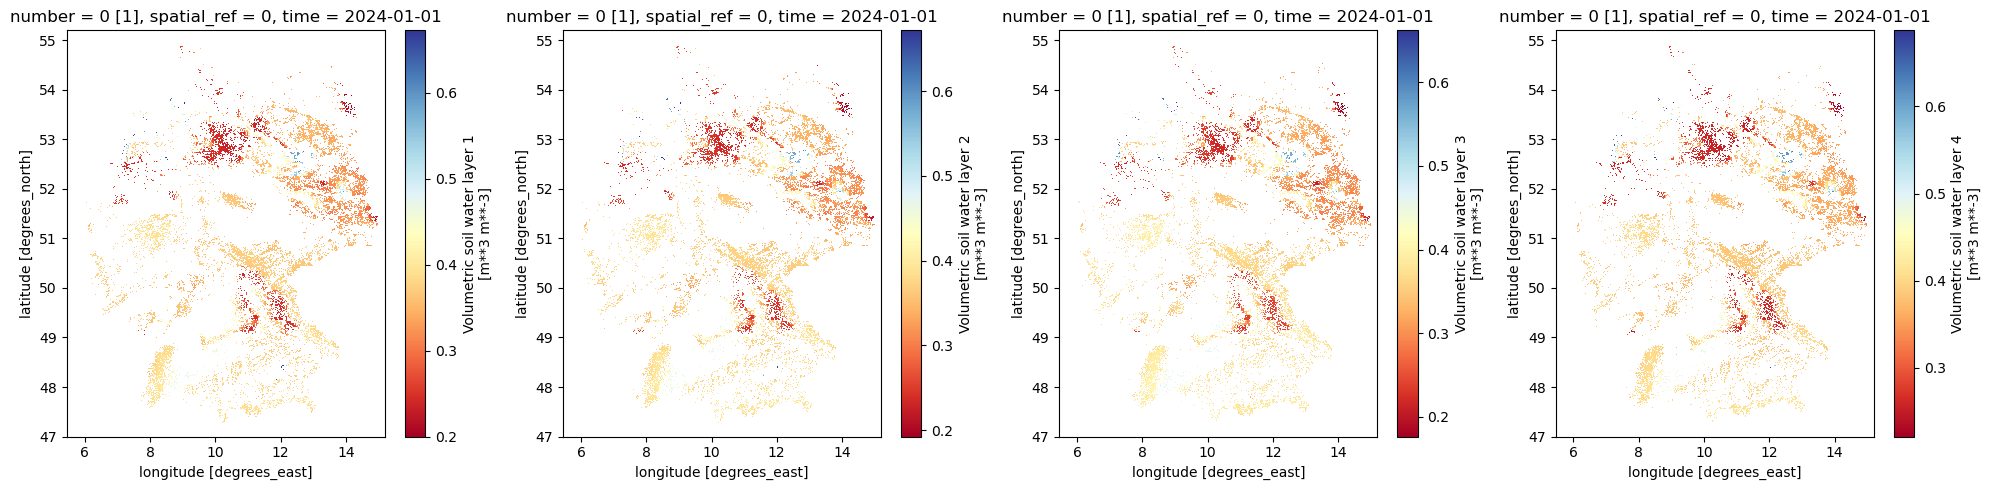

In [7]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
swvl1_NL.plot(ax=axs[0], cmap='RdYlBu')
swvl2_NL.plot(ax=axs[1], cmap='RdYlBu')
swvl3_NL.plot(ax=axs[2], cmap='RdYlBu')
swvl4_NL.plot(ax=axs[3], cmap='RdYlBu')
plt.tight_layout()

In [8]:
# spatially aggregate yearly data
# to get mean values for Germany and federal states

In [9]:
# create list with forest types
forest_types = ("NL", "BL")

# create list of variables to process
# four soil water volume layers with different depths
vars = ("swvl1", "swvl2", "swvl3", "swvl4")

# also create list of folders where datasets are stored
folders = ("Soil_Water_1", "Soil_Water_2", "Soil_Water_3", "Soil_Water_4")

In [10]:
for v in range(len(vars)):
    
    # select variable (soil water volume layer 1-4)
    variable = vars[v]
    folder = folders[v]
        
    # process needleleaved and broadleaved forest
    for f in range(len(forest_types)):
        forest_type = forest_types[f]

        # load all yearly soil moisture values as one dataset
        directory = f"./Climate/{folder}/Yearly"
        filelist = glob.glob(os.path.join(directory, f"*{forest_type}*.nc"))
        swv_yearly = xr.open_mfdataset(filelist, concat_dim="time", combine="nested", engine="netcdf4")

        # calculate mean values per year for Germany
        swv_yearly_spatial_means = swv_yearly.mean(['lon','lat'], skipna=True).to_dataframe()
        
        # drop unneeded columns
        swv_yearly_spatial_means = swv_yearly_spatial_means.drop(['spatial_ref', 'number'], axis=1)

        # rename column with value to show area
        swv_yearly_spatial_means.rename({variable:"GER"}, axis=1, inplace=True)

        # now, calculate yearly mean values for all federal states
        # get list of shapefiles of all states
        dir = "./Administrative_Borders"
        files = list(pathlib.Path(dir).glob('*.shp'))

        # loop over filelist to process each state
        for f in range(len(files)):
            file = files[f]

            # load state shapefile 
            state = str(file)[23:25]
            state_shp = gpd.read_file(file)

            # reproject shapefile to match netcdf data
            state_shp = state_shp.to_crs(4326)

            # extract one date to create mask of state with dimensions of data
            swv_ex = swv_yearly.sel(time = "1999-01-01", method = "nearest")

            # create mask of research area using the dimensions of the exemplary data
            state_mask = rasterio.features.geometry_mask(state_shp.geometry, 
                                                        out_shape=swv_ex.odc.geobox.shape,
                                                        transform=swv_ex.odc.geobox.affine,
                                                        all_touched=False,
                                                        invert=False)
            
            state_mask = xr.DataArray(state_mask, dims=("lat", "lon"))

            # mask yearly data
            swv_state = swv_yearly[variable].where(~state_mask)

            # calculate yearly mean value of state and extract to dataframe
            swv_state_spatial_means = swv_state.mean(['lon','lat'], skipna=True).to_dataframe()

            # drop unneeded columns
            swv_state_spatial_means = swv_state_spatial_means.drop(['spatial_ref', 'number'], axis=1)

            # add yearly mean values of state to dataframe
            swv_yearly_spatial_means[state] = swv_state_spatial_means[variable]

            # save as csv dataset
            swv_yearly_spatial_means.to_csv(f"./Tables/Spatial_Means/{folder}_Yearly_Spatial_Means_{forest_type}.csv")  

In [11]:
# have a look at an exemplary soil water volume layer
swvl1_NL_table = pd.read_csv("./Tables/Spatial_Means/Soil_Water_1_Yearly_Spatial_Means_NL.csv")
swvl1_BL_table = pd.read_csv("./Tables/Spatial_Means/Soil_Water_1_Yearly_Spatial_Means_BL.csv")

In [12]:
swvl1_NL_table

,time,GER,BB,BE,BW,BY,HB,HE,HH,MV,NI,NW,RP,SH,SL,SN,ST,TH
0,1981-01-01,0.361129,0.374545,0.351616,0.399188,0.354030,0.391306,0.375254,0.338479,0.321394,0.310292,0.370616,0.374351,0.279940,0.375141,0.365915,0.387396,0.371749
1,1982-01-01,0.337630,0.325124,0.306061,0.399424,0.347609,0.371678,0.349062,0.320938,0.286965,0.287932,0.355979,0.349526,0.261531,0.352687,0.325304,0.350346,0.346743
2,1983-01-01,0.339736,0.344313,0.326245,0.389175,0.345339,0.360562,0.342965,0.313446,0.295988,0.282829,0.344698,0.339737,0.254110,0.347130,0.339616,0.358064,0.351157
3,1984-01-01,0.359219,0.369902,0.347749,0.396977,0.355391,0.389106,0.372122,0.334139,0.317799,0.309318,0.365239,0.364516,0.274342,0.362960,0.363411,0.385901,0.373191
4,1985-01-01,0.354871,0.366469,0.340903,0.387692,0.349859,0.390952,0.364283,0.343719,0.321082,0.309208,0.369552,0.353314,0.281584,0.354066,0.359050,0.380346,0.361065
5,1986-01-01,0.354328,0.365777,0.342049,0.395978,0.353943,0.372997,0.363015,0.325999,0.312154,0.297119,0.355628,0.362273,0.264555,0.366873,0.359022,0.378659,0.368585
6,1987-01-01,0.367332,0.382062,0.363598,0.404549,0.362602,0.401835,0.376652,0.350407,0.330703,0.317820,0.371836,0.375047,0.289583,0.378554,0.370054,0.391527,0.375082
7,1988-01-01,0.346763,0.348532,0.322557,0.397604,0.352292,0.383395,0.345589,0.335936,0.306765,0.295812,0.351106,0.347282,0.277878,0.361274,0.349049,0.362875,0.351713
8,1989-01-01,0.337527,0.328474,0.304851,0.386330,0.351407,0.369643,0.346794,0.320591,0.280141,0.285521,0.340714,0.342354,0.255350,0.347143,0.342792,0.348241,0.354220
9,1990-01-01,0.342338,0.352534,0.332288,0.381095,0.343672,0.378541,0.345386,0.332105,0.310159,0.292681,0.346962,0.336101,0.273355,0.340477,0.340461,0.362884,0.350318


In [13]:
swvl1_BL_table

,time,GER,BB,BE,BW,BY,HB,HE,HH,MV,NI,NW,RP,SH,SL,SN,ST,TH
0,1981-01-01,0.376253,0.382920,0.351414,0.408824,0.380687,0.391007,0.375720,0.301937,0.350997,0.368644,0.367125,0.374957,0.314347,0.373276,0.367056,0.368592,0.366507
1,1982-01-01,0.353339,0.336760,0.307717,0.404347,0.369598,0.373562,0.349408,0.284104,0.315517,0.343856,0.346069,0.349307,0.293350,0.348943,0.319458,0.324002,0.326379
2,1983-01-01,0.349099,0.354144,0.327076,0.394270,0.363554,0.363671,0.342142,0.276872,0.324764,0.338974,0.337787,0.338698,0.286793,0.344179,0.339251,0.337943,0.334704
3,1984-01-01,0.372474,0.379610,0.346514,0.407171,0.379735,0.388053,0.371308,0.297106,0.346553,0.367442,0.359626,0.365183,0.308087,0.361946,0.365612,0.370127,0.368963
4,1985-01-01,0.365525,0.375630,0.340285,0.392354,0.372448,0.391679,0.365958,0.306114,0.351367,0.365809,0.364144,0.354177,0.315655,0.349469,0.356293,0.356310,0.351656
5,1986-01-01,0.366951,0.375620,0.342850,0.405709,0.377388,0.374400,0.361943,0.288396,0.341133,0.359725,0.351276,0.361371,0.297762,0.366821,0.359417,0.361643,0.360300
6,1987-01-01,0.380438,0.393849,0.363183,0.415161,0.387783,0.402482,0.375967,0.313042,0.360375,0.376150,0.368947,0.374389,0.325059,0.378274,0.370763,0.371393,0.369593
7,1988-01-01,0.355119,0.356862,0.323581,0.402309,0.368474,0.387488,0.341600,0.299343,0.339535,0.349575,0.344881,0.344755,0.311426,0.357767,0.345140,0.337457,0.334354
8,1989-01-01,0.348315,0.334066,0.305563,0.391583,0.369189,0.372743,0.345104,0.282540,0.305816,0.341156,0.332911,0.342298,0.287203,0.343221,0.338523,0.330116,0.336028
9,1990-01-01,0.350561,0.364335,0.332620,0.386877,0.362710,0.382715,0.344718,0.294598,0.339946,0.347914,0.339395,0.336520,0.307434,0.339521,0.337517,0.336007,0.337479
